## Business Objectives


•	Adjusted for inflation do most movies breakeven?

•	Are movie runtimes significantly increasing and is it impacting viewer reviews?

•	Is there a relationship between the budget and revenue or movie popularity?

•	Is it possible to forecast revenue with the data provided?


## Data Import

In [48]:
# Data Analysis Import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
# Impport Data File
df = pd.read_csv("TMDB_movie_dataset_v11.csv")
cpi = pd.read_excel("CPI_scores.xlsx")

## Data Cleaning

In [3]:
df.shape

(1139790, 24)

In [4]:
df.describe()

,id,vote_average,vote_count,revenue,runtime,budget,popularity
count,1139790.00,1139790.00,1139790.00,1139790.00,1139790.00,1139790.00,1139790.00
mean,742425.31,1.88,18.82,690230.32,47.71,267821.93,1.23
std,396763.49,3.02,318.07,17928318.39,61.66,5068141.23,7.58
min,2.00,0.00,0.00,-12.00,-28.00,0.00,0.00
25%,411802.25,0.00,0.00,0.00,0.00,0.00,0.60
50%,747428.50,0.00,0.00,0.00,22.00,0.00,0.60
75%,1094883.75,4.70,1.00,0.00,89.00,0.00,0.88
max,1395219.00,10.00,34495.00,3000000000.00,14400.00,999999999.00,2994.36


In [5]:
# Find missing values
df.isna().sum()

id                            0
title                        13
vote_average                  0
vote_count                    0
status                        0
release_date             188181
revenue                       0
runtime                       0
adult                         0
backdrop_path            837516
budget                        0
homepage                1019128
imdb_id                  536315
original_language             0
original_title               13
overview                 231867
popularity                    0
poster_path              360218
tagline                  980040
genres                   457299
production_companies     625787
production_countries     505582
spoken_languages         486279
keywords                 831367
dtype: int64

In [6]:
# Remove uneeded columns 
df.drop(['id','title','adult','backdrop_path','homepage','imdb_id','original_language','original_title','overview', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries','spoken_languages','keywords'],axis=1, inplace=True)

In [7]:
# What percent of movies are missing their release date?
df['release_date'].isna().sum()/df.shape[0]

0.1651014660595373

In [8]:
# Let's also remove missing release dates. While 16% of the data has a missing release date, it would not be possible to impute without a substainial lift
df = df.dropna(subset=['release_date'])

In [9]:
# Release Date will need to be timestamp
df.dtypes

vote_average    float64
vote_count        int64
status           object
release_date     object
revenue           int64
runtime           int64
budget            int64
popularity      float64
dtype: object

In [10]:
# Convert release to timestamp
df['release_date'] = pd.to_datetime(df['release_date'])

## Feature Engineering

In [11]:
# We need to adjust revenue and budgets for inflatio, make a column for the year
# Let's pull in the data from the CPI table
df['year'] = df['release_date'].dt.year

In [12]:
# Rename column
cpi = cpi.rename(columns={'Year':'year'})

In [13]:
# Data was pulled from website, need to reformat
def clean_year(value):
    value = str(value)
    if '\xa0' in value:
        return value.replace('\xa0','').strip()
    return value

In [14]:
# Clean the CPI year columns
cpi['year'] = cpi['year'].apply(clean_year)
cpi['year'] = pd.to_datetime(cpi['year'])
cpi['year']= cpi['year'].dt.year

In [15]:
# Join the two dataframes on year
dfWithCPI = pd.merge(df,cpi, on='year', how='left')

In [16]:
# CPIs are only reliable from 1913-2024, remove other years
dfWithCPI = dfWithCPI.dropna(subset=['Annual Average CPI'])

In [17]:
# Add current CPI for all rows 
dfWithCPI["current_cpi"] = 314.4

In [19]:
# Calculate the adjsuted revenues and budgets with inflation 
dfWithCPI['adj_revenue'] = dfWithCPI["revenue"] * (dfWithCPI['current_cpi']/dfWithCPI['Annual Average CPI'])
dfWithCPI['adj_budget'] = dfWithCPI["budget"] * (dfWithCPI['current_cpi']/dfWithCPI['Annual Average CPI'])

## Data Analysis

Adjusted for inflation do most movies breakeven or turn a profit?

In [20]:
# Calculate how many movies have broke even or earned more after being adjusted for inflation
dfWithCPI['breakeven'] = np.where(dfWithCPI['adj_revenue'] >= dfWithCPI['adj_budget'], 'Y', 'N')

<Axes: xlabel='breakeven', ylabel='count'>

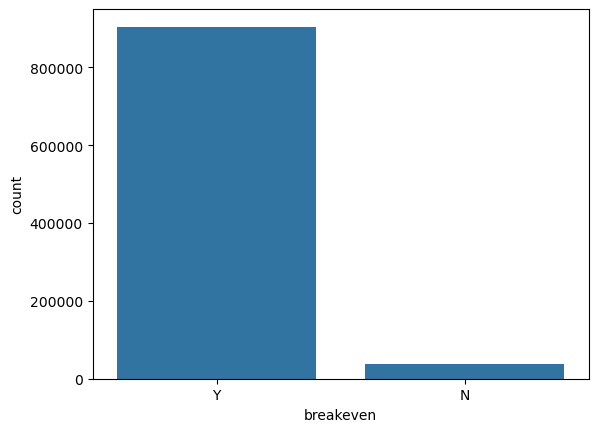

In [21]:
sns.countplot(x='breakeven',data=dfWithCPI)

Are movie runtimes significantly increasing and is it impacting viewer reviews?

Is there a relationship between the budget and revenue or movie popularity?

In [22]:
# Aggregate the average runtime per year
average_runtime = dfWithCPI.groupby('year')['runtime'].mean().reset_index()

<Axes: xlabel='year', ylabel='runtime'>

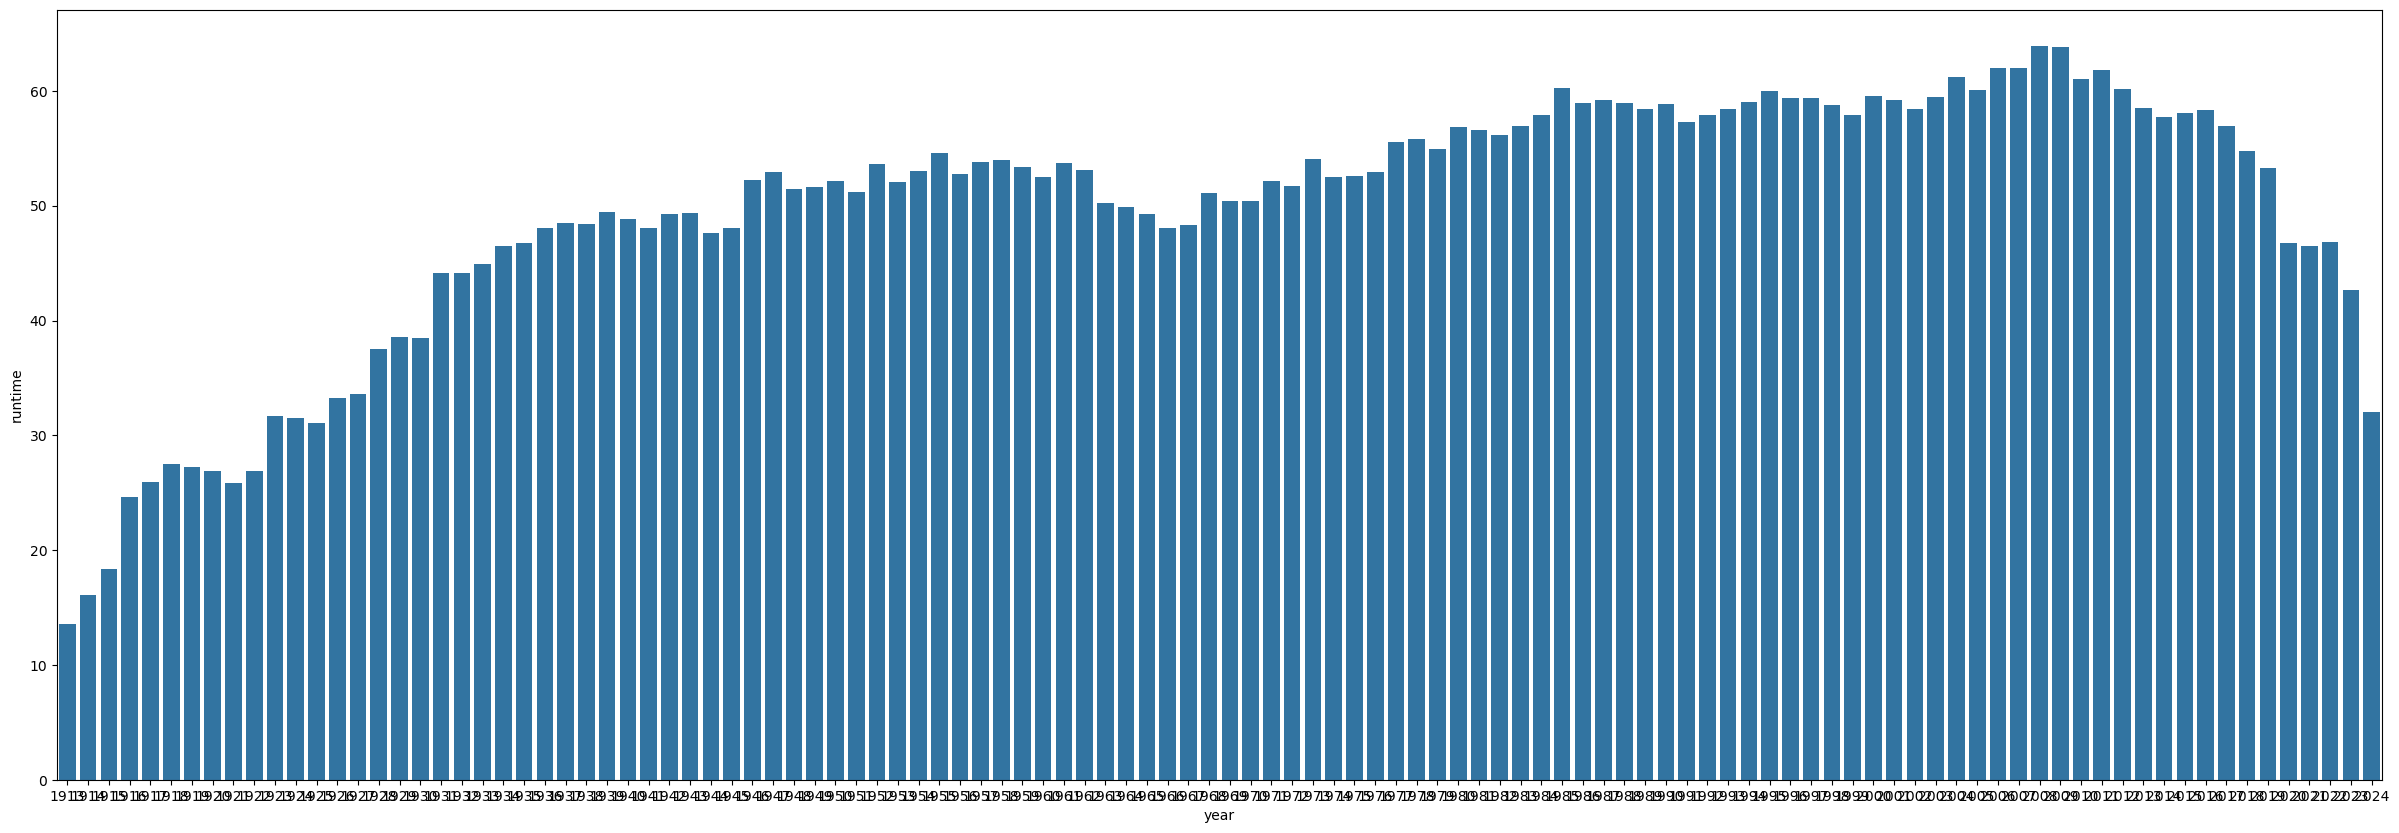

In [24]:
# Movies have slightly been increasing run time over time
plt.figure(figsize=(30,10))
sns.barplot(x='year', y='runtime', data=average_runtime)

In [28]:
# Create numeric dataframe for correlation analysis 
numeric_df = dfWithCPI.select_dtypes(include='number')

<Axes: >

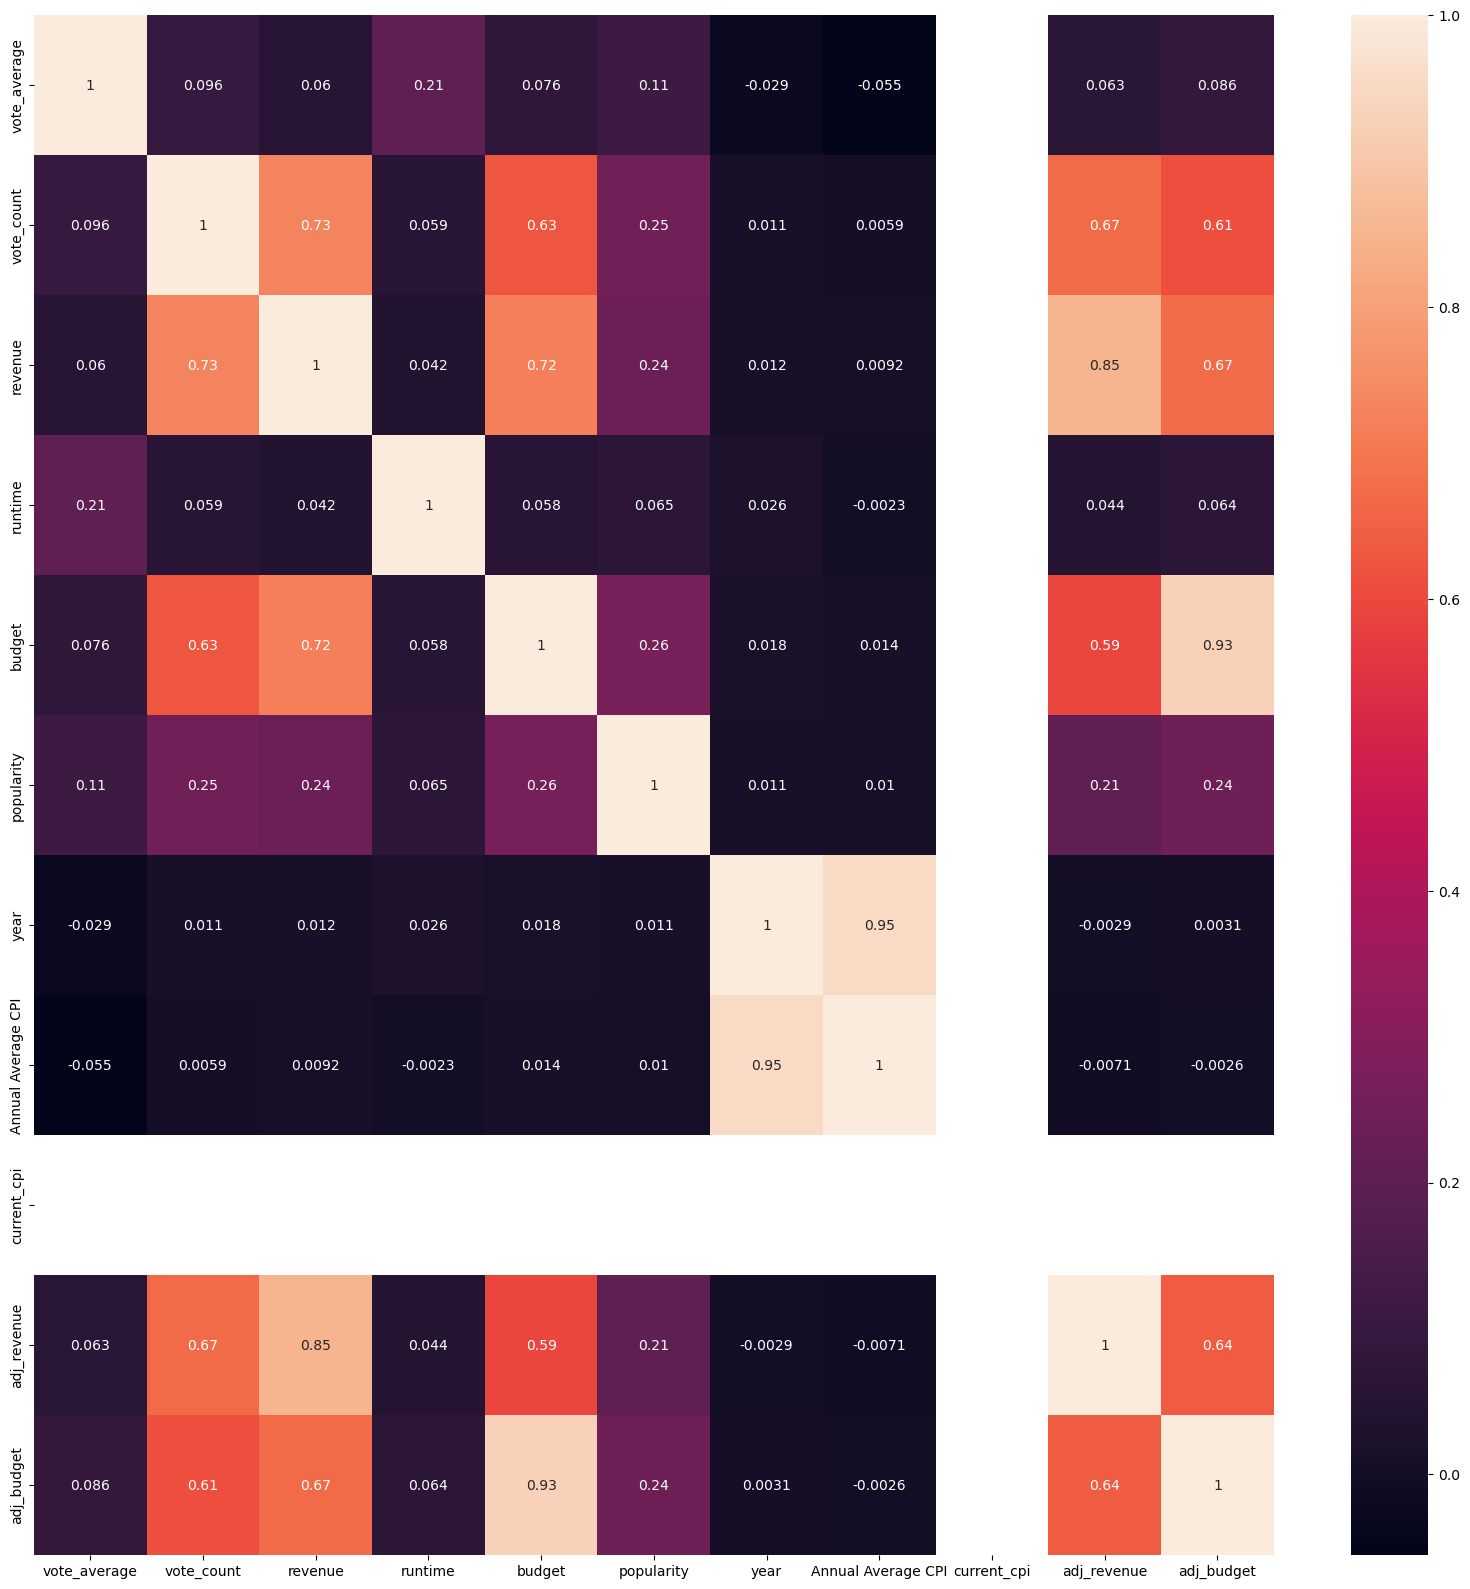

In [31]:
plt.figure(figsize=(10,10))
sns.heatmap(numeric_df.corr(),annot=True)

## Linear Regression

Is it possible to forecast revenue with 95% confidence?

In [32]:
# Based on the corrlatrion analysis, we can drop columns with multicollinearity
dfWithCPI.drop(['budget','revenue'],axis=1,inplace=True)

In [36]:
# Should also drop columns that don't make sense in forecasting revenue.
dfWithCPI.drop(['vote_average','vote_count','status','year','Annual Average CPI','current_cpi','breakeven'],axis=1, inplace=True)

In [43]:
# Year most likely won'e be helpful but month of release could be useful information. let's add that feature
dfWithCPI['month'] = dfWithCPI['release_date'].dt.month

In [45]:
dfWithCPI.drop(['release_date'],axis=1, inplace=True)

In [49]:
# We have no categorical values, so no need to covnert to dummies

In [52]:
# Let's remove the target variable from the input features
y = dfWithCPI['adj_revenue']
X = dfWithCPI[['runtime', 'adj_budget', 'month']]

In [53]:
# Standardize data prior to model implementation
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)

In [54]:
# Split the data train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_df,y, test_size=0.3, random_state=101)

In [55]:
# Initiate Linear Regression
lm = LinearRegression()

In [63]:
# Fit to the train data and test on the training data
lm.fit(X_train,y_train)
y_train_pred = lm.predict(X_train)
mean_squared_error(y_train,y_train_pred)

626337531588837.4

In [60]:
# Test on the testing data
y_test_pred = lm.predict(X_test)
mean_squared_error(y_test,y_test_pred)

In [ ]:
# Overall this is a bad model but good starting point. No signs of overfitting, instead underfitting based on results.
# More relevant features would need to be added to reliablely predict movie revenue. 